link to github -->https://github.com/dafar367/inceptionV3_skin && https://github.com/dafar367/Resnet50_skin


link to drive --> https://drive.google.com/drive/folders/1Fpe9wQMYYQFzfG20Q7mOCgTnLMw3iVQp?usp=share_link


# 0. check running environment 


In [1]:
import tensorflow as tf
from tensorflow.python.client import device_lib


print("Number gpu's available : ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.config.experimental.list_physical_devices('GPU'))
print(device_lib.list_local_devices())

Number gpu's available :  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3356128751232743896
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14328594432
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15908177535976943078
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


# 1. mounting google drive 

In [2]:
from google.colab import drive 
drive.mount("/content/gdrive")

Mounted at /content/gdrive


# 2. read dataset from gdrive


In [3]:
data_dir = '/content/gdrive/MyDrive/computerVision/w9/skin2'

width  = 224
height = 224

batchSize = 32

In [4]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_ds = image_dataset_from_directory(
    data_dir+"/train",
    validation_split = 0.2,
    subset = 'training',
    seed = 12,
    image_size = (width, height),
    batch_size = batchSize,
    label_mode = 'categorical'
)

validation_ds = image_dataset_from_directory(
    data_dir+"/train",
    validation_split = 0.2,
    subset = 'validation',
    seed = 12,
    image_size = (width, height),
    batch_size = batchSize,
    label_mode = 'categorical'
)

Found 210 files belonging to 4 classes.
Using 168 files for training.
Found 210 files belonging to 4 classes.
Using 42 files for validation.


In [5]:
classNames = train_ds.class_names 
print(classNames)

['Combination', 'Dry', 'Normal', 'Oily']


# 3. building model

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Add, AveragePooling2D, Flatten, Dense

def conv_block(inputs, filters, strides=1):
    x = Conv2D(filters, kernel_size=(3, 3), strides=strides, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def identity_block(inputs, filters):
    x = conv_block(inputs, filters)
    x = Conv2D(filters, kernel_size=(3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([x, inputs])
    x = Activation('relu')(x)
    return x

def resnet50(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    x = conv_block(inputs, 64, strides=2)
    x = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)
    
    # Stage 2
    x = identity_block(x, 64)
    x = identity_block(x, 64)
    x = identity_block(x, 64)
    
    # Stage 3
    x = conv_block(x, 128, strides=2)
    x = identity_block(x, 128)
    x = identity_block(x, 128)
    x = identity_block(x, 128)
    
    # Stage 4
    x = conv_block(x, 256, strides=2)
    x = identity_block(x, 256)
    x = identity_block(x, 256)
    x = identity_block(x, 256)
    x = identity_block(x, 256)
    x = identity_block(x, 256)
    
    # Stage 5
    x = conv_block(x, 512, strides=2)
    x = identity_block(x, 512)
    x = identity_block(x, 512)
    
    x = AveragePooling2D(pool_size=(7, 7))(x)
    x = Flatten()(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Create a ResNet-50 model
model = resnet50(input_shape=(224, 224, 3), num_classes=4)


In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 112, 112, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [8]:
from tensorflow.keras.metrics import Recall, Precision
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', Recall(), Precision()])


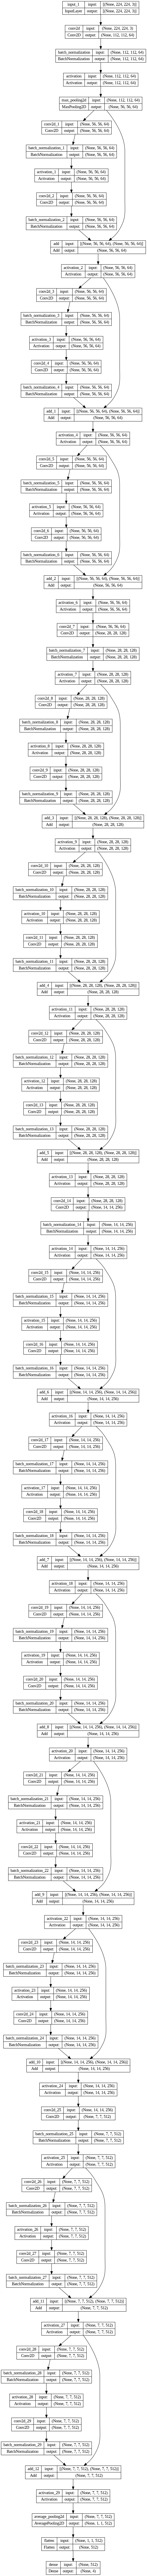

In [9]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='My Model.png', show_shapes=True)

In [ ]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# # Set up data generators for loading images from directories
# datagen = ImageDataGenerator(rescale=1./255)

# train_generator = datagen.flow_from_directory(
#     train_ds,
#     target_size=input_shape[:2],
#     batch_size=32,
#     class_mode='categorical'
# )

# val_generator = datagen.flow_from_directory(
#     validation_ds,
#     target_size=input_shape[:2],
#     batch_size=32,
#     class_mode='categorical'
# )

# test_generator = datagen.flow_from_directory(
#     test_dir,
#     target_size=input_shape[:2],
#     batch_size=32,
#     class_mode='categorical'
# )

NameError: ignored

# 4. training model


In [11]:
from datetime import datetime

epochs=150
history = model.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=epochs
)
model.save('/content/gdrive/MyDrive/computerVision/w9/code/modelResNet.h5')

Epoch 1/150
6/6 [==============================] - 2s 214ms/step - loss: 0.3113 - accuracy: 0.9167 - recall: 0.9167 - precision: 0.9222 - val_loss: 126.3714 - val_accuracy: 0.3095 - val_recall: 0.3095 - val_precision: 0.3095
Epoch 2/150
6/6 [==============================] - 2s 213ms/step - loss: 0.2163 - accuracy: 0.9405 - recall: 0.9286 - precision: 0.9455 - val_loss: 88.9399 - val_accuracy: 0.1429 - val_recall: 0.1429 - val_precision: 0.1463
Epoch 3/150
6/6 [==============================] - 2s 188ms/step - loss: 0.1714 - accuracy: 0.9524 - recall: 0.9345 - precision: 0.9573 - val_loss: 21.6787 - val_accuracy: 0.2143 - val_recall: 0.2143 - val_precision: 0.2143
Epoch 4/150
6/6 [==============================] - 2s 275ms/step - loss: 0.1640 - accuracy: 0.9524 - recall: 0.9464 - precision: 0.9578 - val_loss: 2.9633 - val_accuracy: 0.4524 - val_recall: 0.4524 - val_precision: 0.4524
Epoch 5/150
6/6 [==============================] - 2s 220ms/step - loss: 0.0958 - accuracy: 0.9821 - rec

# 5.evaluation 

In [12]:
import numpy as np 

# print("duration : "+str(end_time - start_time))
print("average loss : ", np.average(history.history['loss']))
print("average accuracy : ", np.average(history.history['accuracy']))
print("average recall : ", np.average(history.history['recall']))
print("average precision : ", np.average(history.history['precision']))

print()

print("average val loss : ", np.average(history.history['val_loss']))
print("average val accuracy : ", np.average(history.history['val_accuracy']))
print("average recall : ", np.average(history.history['val_recall']))
print("average precision : ", np.average(history.history['val_precision']))



average loss :  0.12229046853880088
average accuracy :  0.9644047605991364
average recall :  0.9626587291558584
average precision :  0.9657982405026754

average val loss :  6.923396706183752
average val accuracy :  0.5106349270542463
average recall :  0.5050793712337812
average precision :  0.5153292092680931


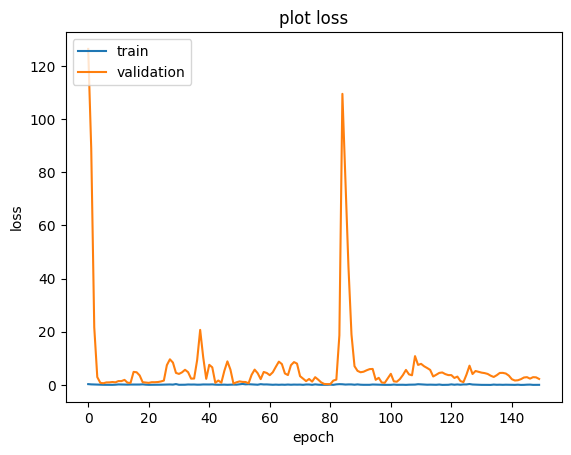

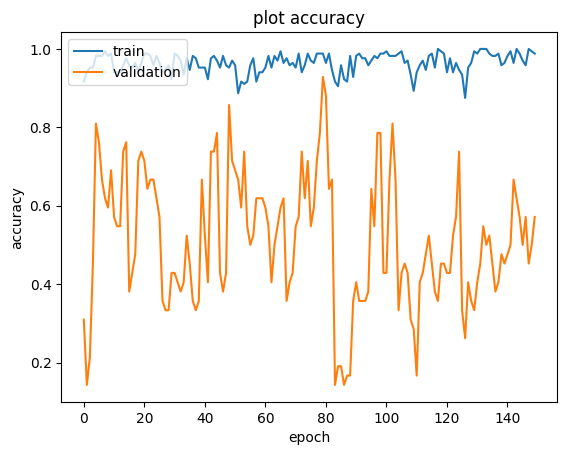

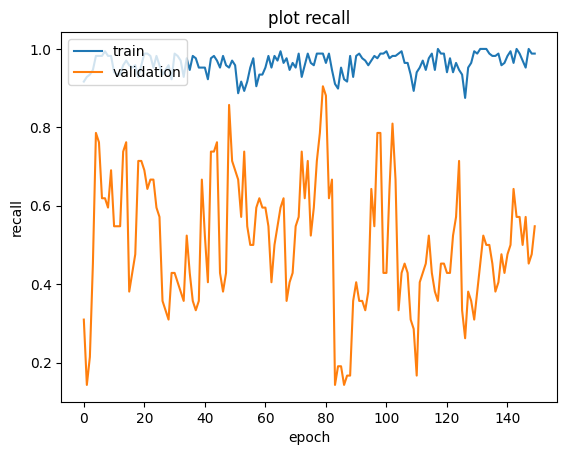

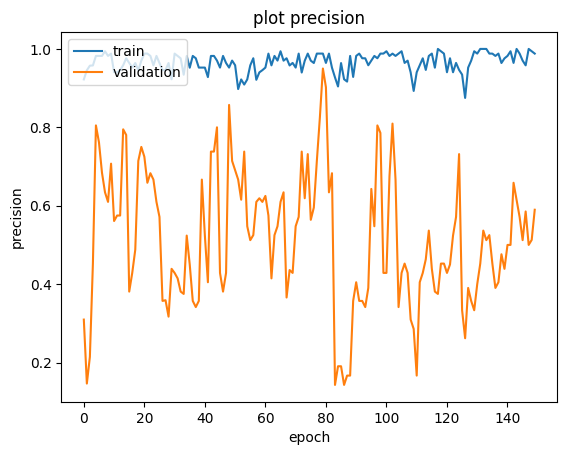

In [13]:
import matplotlib.pyplot as plt

def plot_history(hist, label):
  plt.plot(hist.history[label])
  plt.plot(hist.history['val_'+label])
  plt.title('plot '+label)
  plt.ylabel(label)
  plt.xlabel("epoch")
  plt.legend(['train','validation'], loc='upper left')
  plt.show()

plot_history(history, 'loss')
plot_history(history, 'accuracy')
plot_history(history, 'recall')
plot_history(history, 'precision')


# 6. testing


In [14]:
from tensorflow.keras.models import load_model

loaded_model = load_model('/content/gdrive/MyDrive/computerVision/w9/code/modelResNet.h5')
loaded_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 112, 112, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.math import confusion_matrix



test_data = ImageDataGenerator()

test_ds = test_data.flow_from_directory(
    "/content/gdrive/MyDrive/computerVision/w9/skin/test",
    target_size=(width, height),
    batch_size=batchSize,
    class_mode = 'categorical'
)

class_names = []
for key, value in test_ds.class_indices.items():
  class_names.append(key)

predictions = np.array([])
labels = np.array([])

for x, y in test_ds:
  predictions = np.concatenate([predictions, np.argmax(loaded_model.predict(x), axis = -1)])
  labels = np.concatenate([labels, np.argmax(y, axis = -1)])

matrix = confusion_matrix(labels = labels, predictions = predictions).numpy()

df = pd.DataFrame(matrix, columns = class_names, index = class_names)
df

Found 78 images belonging to 4 classes.
1/1 [==============================] - 0s 28ms/step


In [ ]:
import seaborn as sns 
sns.heatmap(df, annot = True, fmt='d')

NameError: ignored

In [15]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.math import confusion_matrix

test_data = ImageDataGenerator()
test_ds = test_data.flow_from_directory(
    "/content/gdrive/MyDrive/computerVision/w9/skin2/test",
    target_size=(width, height),
    batch_size=batchSize,
    class_mode = 'categorical',
)

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

predict = loaded_model.predict_generator(test_ds,steps=len(test_ds),verbose=1)
test_labels=test_ds.classes
confusion_matrix(test_labels, predict.argmax(axis=1))

# # Make predictions on the test dataset
# predictions = loaded_model.predict(test_ds)

# # Convert predicted probabilities to class labels
# predicted_labels = np.argmax(predictions, axis=1)

# # Get the true labels for the test dataset
# true_labels = test_ds.classes

# # Compute confusion matrix
# matrix = confusion_matrix(true_labels, predicted_labels)

# # Create a DataFrame from the confusion matrix
# df = pd.DataFrame(matrix)

# # Display the confusion matrix
# print(df)


Found 210 images belonging to 4 classes.


<ipython-input-15-186029f566b9>:18: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = loaded_model.predict_generator(test_ds,steps=len(test_ds),verbose=1)


7/7 [==============================] - 52s 9s/step


array([[10, 13,  1, 21],
       [13, 18,  0, 20],
       [ 6, 26,  2, 20],
       [19, 19,  2, 20]])

In [16]:
from sklearn.metrics import classification_report
cr_labels = list(test_ds.class_indices.keys())
classification_report(test_labels, predict.argmax(axis=1), target_names=cr_labels)

'              precision    recall  f1-score   support\n\n Combination       0.21      0.22      0.22        45\n         Dry       0.24      0.35      0.28        51\n      Normal       0.40      0.04      0.07        54\n        Oily       0.25      0.33      0.28        60\n\n    accuracy                           0.24       210\n   macro avg       0.27      0.24      0.21       210\nweighted avg       0.28      0.24      0.21       210\n'

7/7 [==============================] - 2s 240ms/step


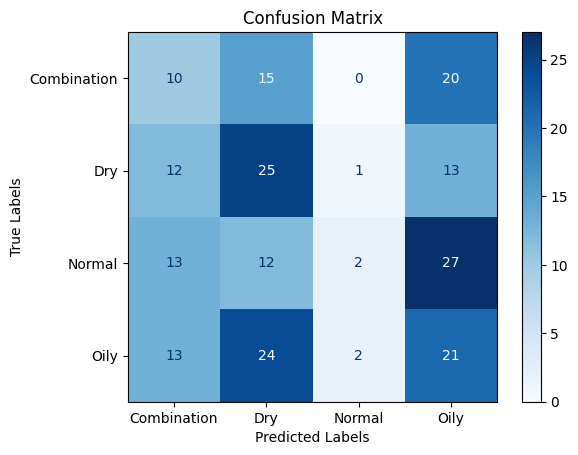

              precision    recall  f1-score    support
Combination    0.208333  0.222222  0.215054   45.00000
Dry            0.328947  0.490196  0.393701   51.00000
Normal         0.400000  0.037037  0.067797   54.00000
Oily           0.259259  0.350000  0.297872   60.00000
accuracy       0.276190  0.276190  0.276190    0.27619
macro avg      0.299135  0.274864  0.243606  210.00000
weighted avg   0.301461  0.276190  0.244236  210.00000


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

predictions = loaded_model.predict(test_ds)
# Get the predicted labels and true labels
predicted_labels = np.argmax(predictions, axis=1)
true_labels = test_ds.classes

# Compute the classification report
report = classification_report(true_labels, predicted_labels, target_names=cr_labels, output_dict=True)

# Convert the classification report to a DataFrame
df = pd.DataFrame(report).transpose()

# Plot the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cr_labels)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Display the classification report DataFrame
print(df)


In [33]:
model_json = loaded_model.to_json()
with open("/content/gdrive/My Drive/model.json","w") as json_file:
  json_file.write(model_json)

In [53]:
def predict_(image_path):
    #Load the Model from Json File
    json_file = open('/content/gdrive/MyDrive/model.json', 'r')
    model_json_c = json_file.read()
    json_file.close()
    model_c = model_from_json(model_json_c)
    #Load the weights
    model_c.load_weights("/content/gdrive/MyDrive/computerVision/w9/code/modelResNet.h5")
    #Compile the model
    opt = SGD(lr=1e-4, momentum=0.9)
    model_c.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])
    #load the image you want to classify
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224,224))
    cv2_imshow(image)
    #predict the image
    preds = model_c.predict(np.expand_dims(image, axis=0))[0]
    if preds.any() == 0:
      print("Predicted Label: dry")
    elif preds.any() == 1:
      print("Predicted Label: combination")
    elif preds.any() == 2:
      print("Predicted Label: oily")
    elif preds.any() == 3:
      print("Predicted Label: normal")


In [48]:
from keras.models import model_from_json
from keras.optimizers import SGD
import cv2
from google.colab.patches import cv2_imshow


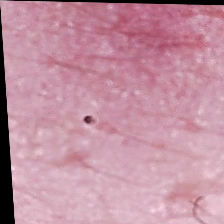

1/1 [==============================] - 1s 746ms/step
Predicted Label: combination


In [54]:
predict_("/content/gdrive/MyDrive/computerVision/w9/skin2/test/Combination/augCombi_10_jpg.rf.44358ae3a0a5417eb245bd74a434e78b.jpg")